In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import waveresponse as wr
import warnings
warnings.filterwarnings("ignore") 

df = pd.read_csv('resources/diffraction_data.csv')
df

,omega,radiating_dof,influenced_dof,wave_direction,added_mass,radiation_damping,inertia_matrix,hydrostatic_stiffness,g,rho,...,wavenumber,wavelength,diffraction_force_real,diffraction_force_imag,Froude_Krylov_force_real,Froude_Krylov_force_imag,excitation_force_real,excitation_force_imag,RAO_real,RAO_imag
0,0.1,Surge,Surge,0.000000,238.259297,3.888155e-07,791.856048,0.0,9.81,1025.0,...,0.002337,2688.270531,8.905720e-08,-5.460331e+00,-4.547474e-13,-1.815217e+01,8.905674e-08,-2.361250e+01,2.316635e-12,2.292232e+00
1,0.1,Surge,Surge,0.261799,238.259297,3.888155e-07,791.856048,0.0,9.81,1025.0,...,0.002337,2688.270531,8.602265e-08,-5.274275e+00,0.000000e+00,-1.753365e+01,8.602265e-08,-2.280793e+01,2.195148e-12,2.214126e+00
2,0.1,Surge,Surge,0.523599,238.259297,3.888155e-07,791.856048,0.0,9.81,1025.0,...,0.002337,2688.270531,7.712581e-08,-4.728788e+00,0.000000e+00,-1.572025e+01,7.712581e-08,-2.044903e+01,1.968339e-12,1.985132e+00
3,0.1,Surge,Surge,1.570796,238.259297,3.888155e-07,791.856048,0.0,9.81,1025.0,...,0.002337,2688.270531,-1.110223e-16,-2.706169e-16,-4.547474e-13,-1.026956e-15,-4.548584e-13,-1.297573e-15,4.409849e-14,1.186694e-16
4,0.1,Surge,Surge,3.141593,238.259297,3.888155e-07,791.856048,0.0,9.81,1025.0,...,0.002337,2688.270531,-8.905720e-08,5.460331e+00,-4.547474e-13,1.815217e+01,-8.905765e-08,2.361250e+01,-2.228502e-12,-2.292232e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,5.0,Yaw,Yaw,0.000000,150.222316,4.206169e+02,312.017176,0.0,9.81,1025.0,...,2.548420,2.465522,-1.705303e-13,3.552714e-13,2.842171e-14,9.094947e-13,-1.421085e-13,1.264766e-12,-2.467901e-17,-8.390715e-17
8996,5.0,Yaw,Yaw,0.261799,150.222316,4.206169e+02,312.017176,0.0,9.81,1025.0,...,2.548420,2.465522,5.057744e+02,2.347275e+02,1.166061e+03,9.663381e-13,1.671836e+03,2.347275e+02,-1.436128e-01,5.824015e-03
8997,5.0,Yaw,Yaw,0.523599,150.222316,4.206169e+02,312.017176,0.0,9.81,1025.0,...,2.548420,2.465522,7.856047e+02,4.076509e+02,2.175469e+03,8.526513e-13,2.961073e+03,4.076509e+02,-2.542366e-01,1.099258e-02
8998,5.0,Yaw,Yaw,1.570796,150.222316,4.206169e+02,312.017176,0.0,9.81,1025.0,...,2.548420,2.465522,-4.973799e-14,7.815970e-14,4.050094e-13,-2.842171e-14,3.552714e-13,4.973799e-14,-2.546568e-17,-1.580800e-17


In [236]:
df_mean = (
    df.groupby(["omega", "radiating_dof"], as_index=False)[["RAO_real", "RAO_imag"]]
      .mean()
)
df_mean

,omega,radiating_dof,RAO_real,RAO_imag
0,0.1,Heave,1.000000e+00,4.883226e-10
1,0.1,Pitch,-6.018449e-13,-8.378122e-04
2,0.1,Roll,3.546586e-15,-2.011679e-18
3,0.1,Surge,8.591436e-13,8.398516e-01
4,0.1,Sway,3.539608e-13,8.062904e-01
...,...,...,...,...
295,5.0,Pitch,5.605590e-02,7.592336e-02
296,5.0,Roll,-7.911840e-18,2.554018e-17
297,5.0,Surge,5.746767e-02,2.426090e-02
298,5.0,Sway,2.504438e-02,8.813347e-02


In [ ]:
# creative wave using jonswap spectrum
# hs - wave height
# tp - peak period
# dirp is peak direction
def create_wave(freq, dirs, hs, tp, dirp):
    _, vals = wr.JONSWAP(freq, freq_hz=True)(hs, tp)
    spread_fun = wr.CosineFullSpreading(s=2, degrees=True)

    wave = wr.WaveSpectrum.from_spectrum1d(
        freq,
        dirs,
        vals,
        spread_fun,
        dirp,
        freq_hz=False,
        degrees=True,
        clockwise=False,
        waves_coming_from=False,
    )
    return wave

In [238]:
def custom_RAO(dof):
    sub = (
        df_mean[df_mean["radiating_dof"] == dof]
        .sort_values("omega")
    )
    omega = sub["omega"].to_numpy()      
    rao_real = sub["RAO_real"].to_numpy()    
    rao_imag = sub["RAO_imag"].to_numpy() 

    dirs = np.array([0.0])                  
    rao_complex = rao_real + 1j * rao_imag
    rao_vals = rao_complex[:, None] 
    
    rao = wr.RAO(
        omega,
        dirs,
        rao_vals,
        freq_hz=False,       
        degrees=True,       
        clockwise=False,
        waves_coming_from=True,
    )
    return rao

In [ ]:

def rao_response_plots(ax, dofs, wave, heading):
    for i, dof in enumerate(dofs):
        rao = custom_RAO(dof)
        response = wr.calculate_response(rao, wave, heading, heading_degrees=True)
        _, response_spectrum = response.spectrum1d(axis=1)
 
        x = np.linspace(0, 5, response_spectrum.size)
        ax[i].plot(x, response_spectrum)
        ax[i].set_title(f'{dof}')
        # ax[i].
    return ax

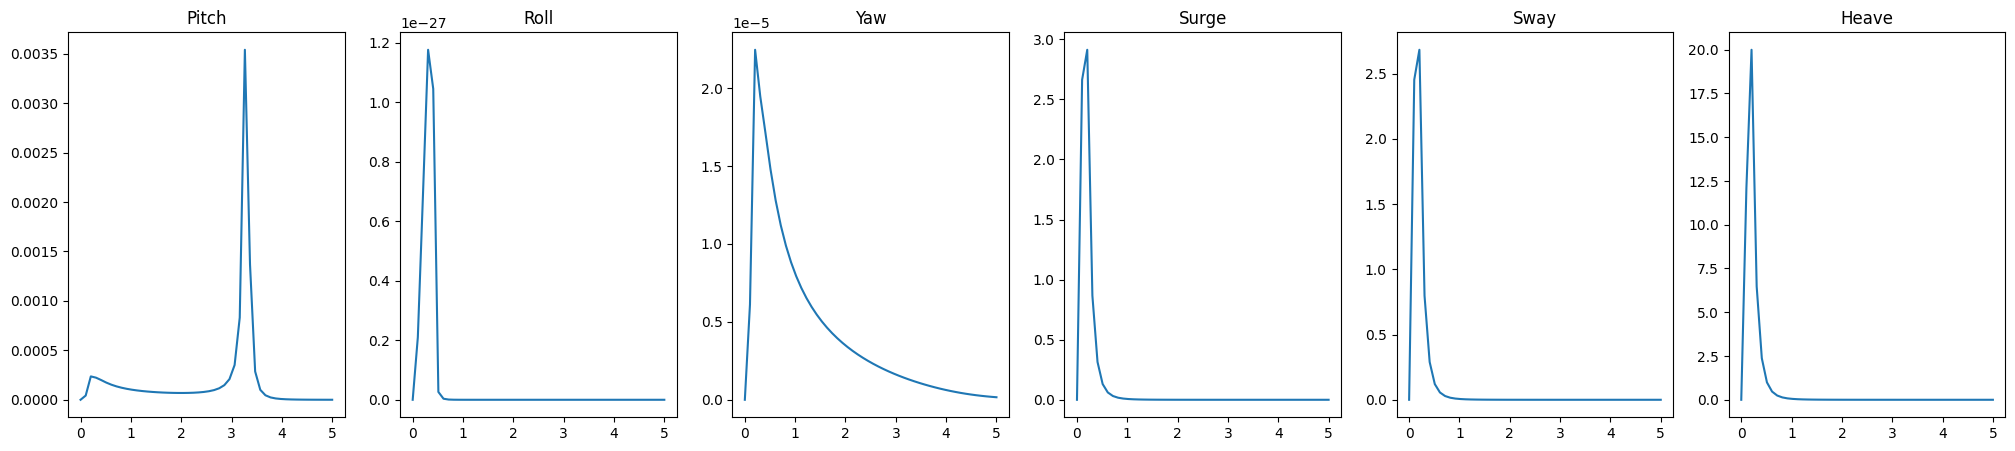

In [ ]:
# create_wave() params
freq = np.linspace(0.1, 5, 50)
dirs = np.linspace(0.0, 360.0, endpoint=False)
hs = 10 
tp = 4 
gamma = 3.3  
dirp = 45.0 

# rao_response_plot() params
heading = 45
dofs = ["Pitch", "Roll", "Yaw", "Surge", "Sway", "Heave"]
fig, ax = plt.subplots(1, 6, figsize=(25, 5))

wave = create_wave(freq, dirs, hs, tp, dirp)
ax = rao_response_plots(ax, dofs, wave, heading)
plt.show()